# Цель
Изучить статистические характеристики метода измерения уровня сигнала. Нужно узнать как меняется уровень сигнала с различных сканеров когда все элементы системы (окружение, сканеры и браслет) находятся в неизменном состоянии.

Понимание статистик позволит понять какое количество сигналов с каждого сканера нужно получить, чтобы  вычислить среднее значение с высокой точность. Также это позволит понять насколько высокая точность необходима, чтобы различать сигнал от конкретного сканера при нахождении браслета в разных помещениях. Знаниче этих характеристик позволит спроектировать наиболее эффективный алгоритм определения положения браслета, который будет брать во внимание полученные характеристики.

Таким образом, в рамках этого исследование необходимо:
1.  Собрать сигналы от браслета в разных положениях в каждой комнате. В каждой комнате положения должны выбираться так, чтобы получить наиболее различные сигналы. По 100 сигналов с каждого сканера в каждом положении браслета. При этом в помещении не должно быть движущихся людей и котов, чтобы собрать максимально чистые данные.
2. Для каждого положения вычислить среднее и дисперсию для каждого сканера.
3. Посмотреть как меняется дисперсия в зависимости от среднего значения (насколько дисперсия увеличивается/уменьшается в зависимости от среднего значения уровня сигнала).
4. Посмотреть как среднее по каждому сканеру меняется в зависимости от помещения. Найти минимальную разницу между средними фиксированного сканера из разных помещений. Посмотреть на распределение разниц между положениями из разных помещений.
5. Посчитать какое количество сигналов нужно, чтобы с высокой вероятностью (p=0.05) уловить разницу между средними из двух положений из разных близких комнат.
6. Подобрать параметры фильтра Калмана, которые максимально быстро приближали бы среднее к значению, позволяющему различить два положения из близкикх комнат.

In [178]:
from server import config
from datetime import datetime
import asyncio
from asyncio_mqtt import Client, MqttError
from contextlib import AsyncExitStack
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing, metrics, linear_model, multiclass, feature_selection, pipeline
from sklearn.cluster import MeanShift
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, SelectorMixin
from sklearn.base import TransformerMixin, BaseEstimator
from server.heartbeat import HeratbeatGenerator
import xgboost
import pandas as pd
import numpy as np
import seaborn as sbs
from matplotlib import pyplot as plt
import jsons
from server.kalman import KalmanRSSI

pd.set_option('display.float_format', '{:.4f}'.format)

## Сбор данных

In [179]:
async def collect_signals(room):
    new_signals = {}
    position = str(datetime.utcnow().timestamp())
    async with Client(
        hostname=config.MQTT_BROKER_URL, port=config.MQTT_BROKER_PORT,
        username=config.MQTT_USERNAME, password=config.MQTT_PASSWORD) as client:
        async with client.unfiltered_messages() as messages:
            await client.subscribe("room_presence/#")
            async for message in messages:
                event = jsons.loads(message.payload.decode())
                if event['id'] != 'eb:cd:02:7f:98:91'.upper():
                    continue

                scanner = message.topic.split('/')[1]
                scanner_signals = new_signals.get(scanner, [])
                scanner_signals.append({'rssi': event['rssi'], 'when': datetime.utcnow()})
                new_signals[scanner] = scanner_signals

                print(dict([(k, len(new_signals[k])) for k in new_signals.keys()]))

                if sum(len(new_signals[k]) >= 8 for k in new_signals.keys()) >= 3:
                    return [
                        {'scanner': s, 'rssi': v['rssi'], 'when': v['when'], 'position': '{}-{}'.format(str(room), str(position)), 'room': room} 
                        for s, values in new_signals.items() for v in values
                    ]

async def collect_and_save_signals(room):
    new_signals = await collect_signals(room)
    df = pd.read_csv('./signals.csv')
    df = pd.concat([df, pd.DataFrame(new_signals)])
    df.to_csv('./signals.csv', index=False)

In [180]:
# await collect_and_save_signals('bedroom')

Во время сбора данных не удалось соблюсти чистоту стерильной комнаты – мимо ходили люди, коты, в некоторых положениях устройство могло сместиться на несколько сантиметров. Для каждого положения сбор данных заканчивался когда количество сигналов с двух сканеров достигало 100 по каждому.

__Предположение__: 100 значений на сканер должно дать приемлемую точность вычисленного среднего сигнала. Нужно в этом убедиться путем анализа распределения в разных положениях, также нужно проверить какой _p_ дает такой объем выборки и какой нужен минимальный объем выборки для приемлемого _p_ чтобы сократить время сбора данных, в каждом положении приходилось ждать от 10 до 20 минут, чтобы собрать 100 сигналов по двум сканерам, это много

## Изучаем статистики

In [181]:
data_df = pd.read_csv('./signals.csv')
data_df['when'] = data_df['when'].astype('datetime64')
data_df['when_ts'] = data_df['when'].apply(lambda x: (x - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's'))
data_df['rssi_bin'] = pd.cut(data_df['rssi'], np.arange(-100, 0, 5))
room_df = data_df[data_df['room'] == 'guest'].copy()

In [182]:
def set_delays(data_df):
    for pos in data_df['position'].unique():
        position_mask = data_df['position'] == pos
        for scanner in data_df.loc[position_mask, 'scanner'].unique():
            scanner_mask = position_mask & (data_df['scanner'] == scanner)
            data_df.loc[scanner_mask, 'delay'] = data_df.loc[scanner_mask, 'when_ts'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
    data_df['delay'].fillna(0, inplace=True)

In [183]:
set_delays(data_df)

<AxesSubplot:xlabel='scanner', ylabel='rssi'>

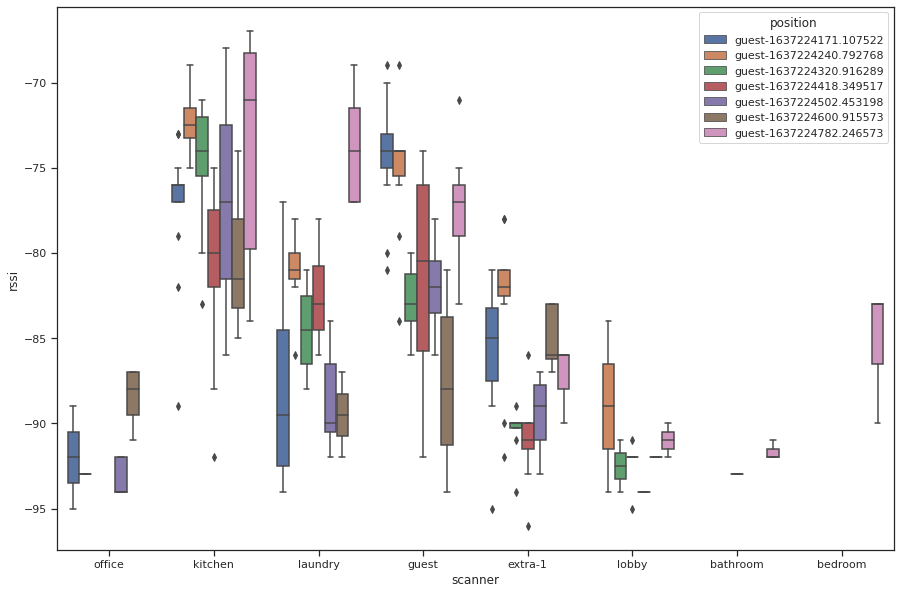

In [184]:
f = plt.figure(figsize=(15, 10))
ax = f.add_subplot(111)
sbs.boxplot(data=room_df, x='scanner', y='rssi', hue='position', ax=ax)

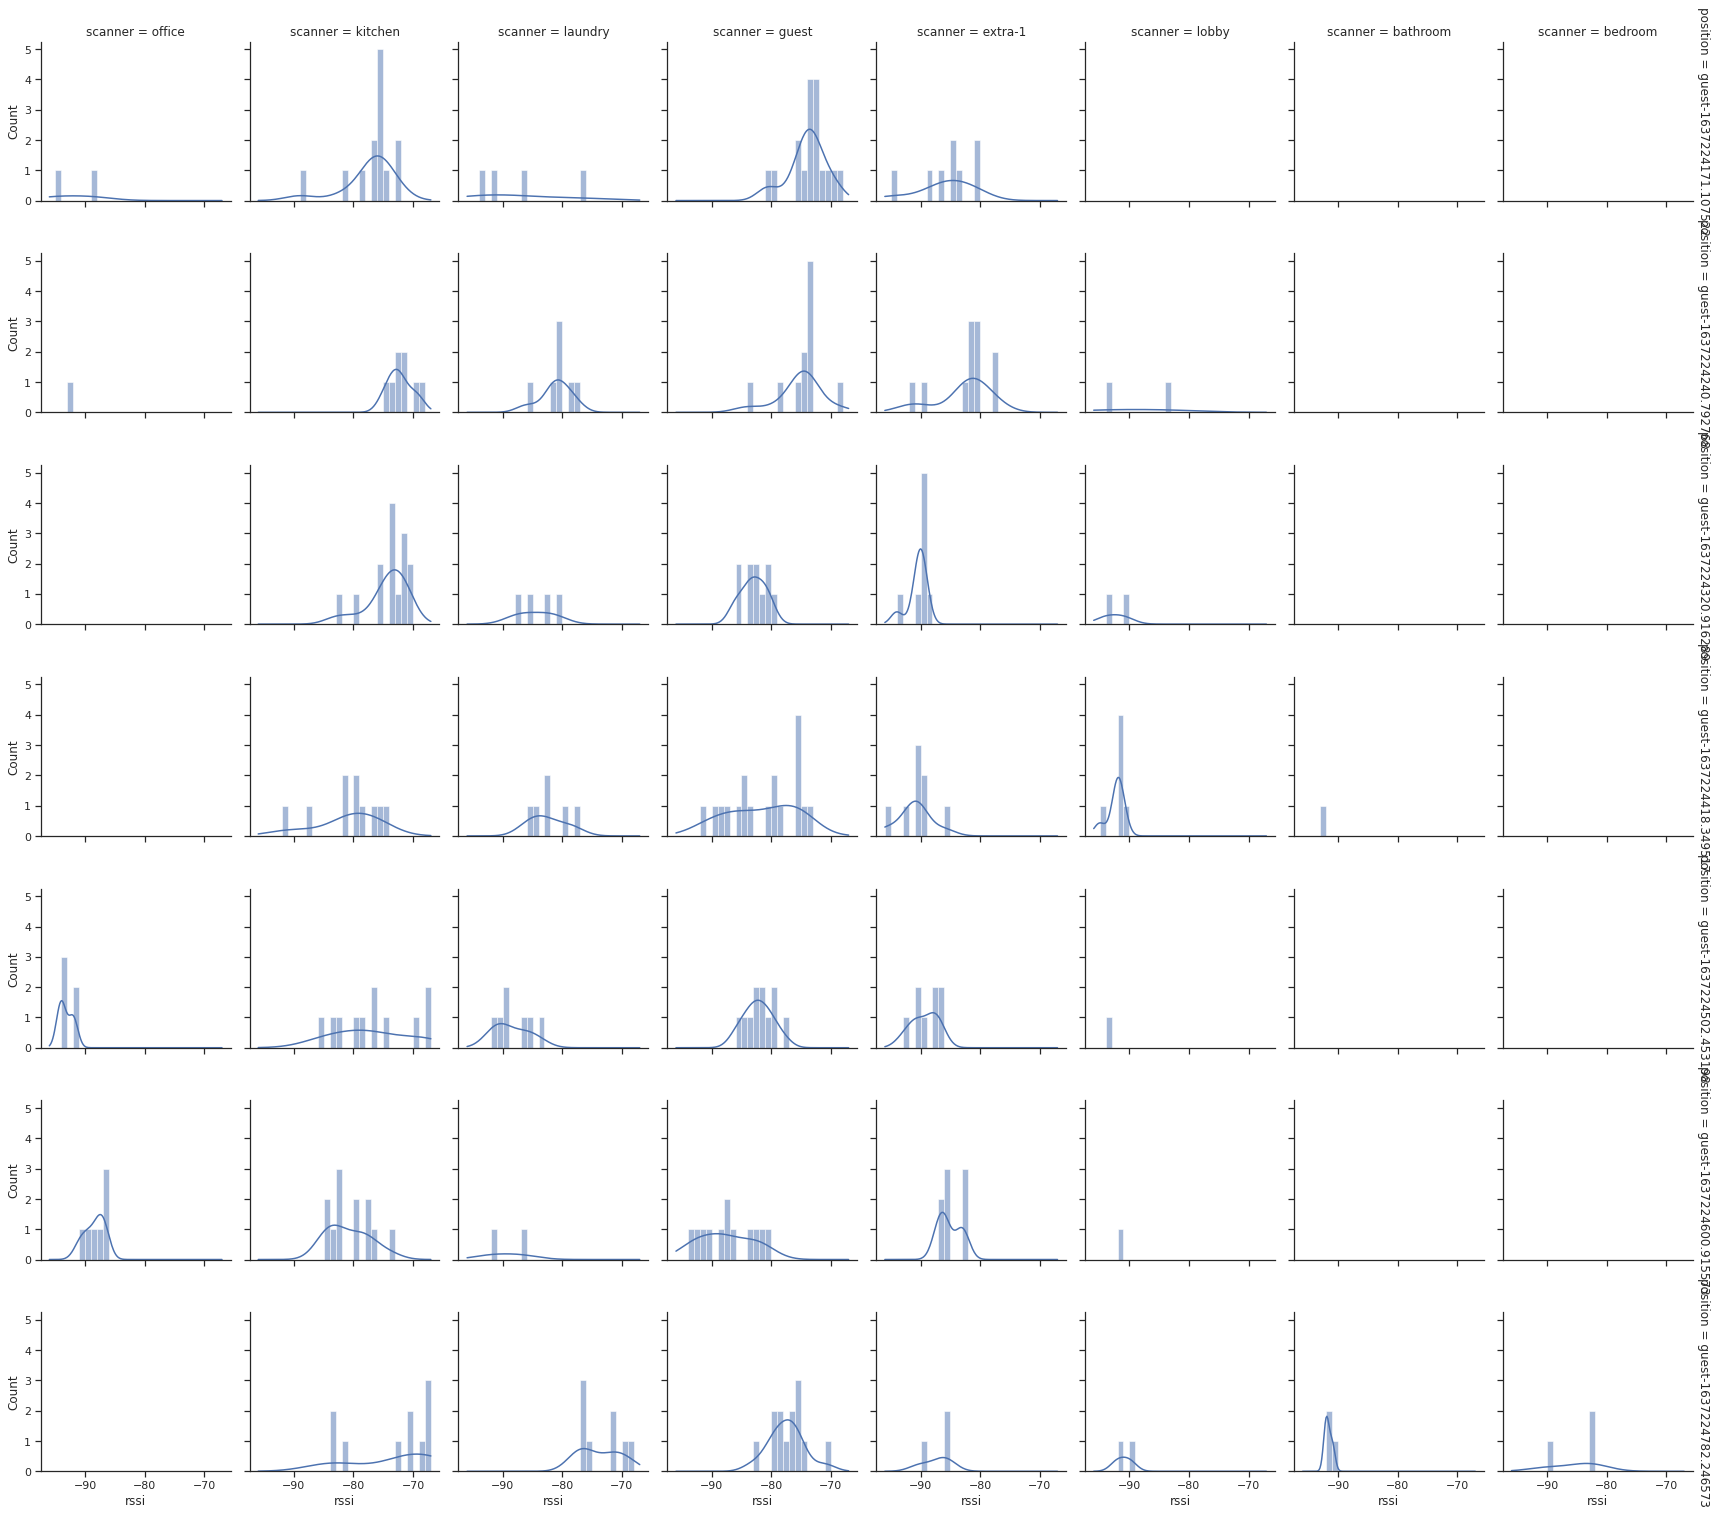

In [185]:
sbs.displot(
    room_df, x="rssi", col="scanner", row="position",
    binwidth=1, height=3, facet_kws=dict(margin_titles=True),
    kind='hist', kde=True,
)

Заметим, что в одном положении сигнал с одного сканера может иметь несколько пиков. Это может говорить о том, что среда каким-то образом изменилась и количество помех увеличилось/уменьшилось, что привело к изменению уровня получаемого со сканера среднего сигнала.

Получим все пики для кадого положения устройства во всех помещениях. Найденные значения - возможные (полученные во время сбора данных) средние  уровня сигнала для каждого помещения.

__Предположение:__ отфильтрованные Калманом значения будут колебаться в приделах этих средних для каждого сканера-помещения.

In [186]:
results_df = []

def get_center_size(data_df, x):
    x = np.round(x)
    return len(data_df[(data_df['rssi'] >= x - 1) & (data_df['rssi'] <= x + 1)])

for room in data_df['room'].unique():
    for scanner in data_df['scanner'].unique():
        for position in data_df['position'].unique():
            curr_data = data_df[(data_df['scanner'] == scanner) & (data_df['position'] == position) & (data_df['room'] == room)]
            X = list(zip(curr_data['rssi'], [1] * len(curr_data['rssi'])))
            if len(X) > 0:
                ms = MeanShift(bandwidth=2).fit(X)
                new_centers = sorted([{
                    'scanner': scanner,
                    'room': room,
                    'position': position,
                    'rssi_center': np.round(x[0]),
                    'size': get_center_size(curr_data, x[0]),
                    'cluster_idx': i,
                } for i, x in enumerate(ms.cluster_centers_)], key=lambda x: -x['size'])

                # Дополнительно отфильтруем низкие пики. Нас не интересуют пики,
                # значение которого вместе с +-1 окрестностью встречалось меньше X раз
                if new_centers[0]['size'] >= 30:
                    results_df += [x for x in new_centers if x['size'] >= 30]
                else:
                    results_df += [new_centers[0]]

results_df = pd.DataFrame(results_df)

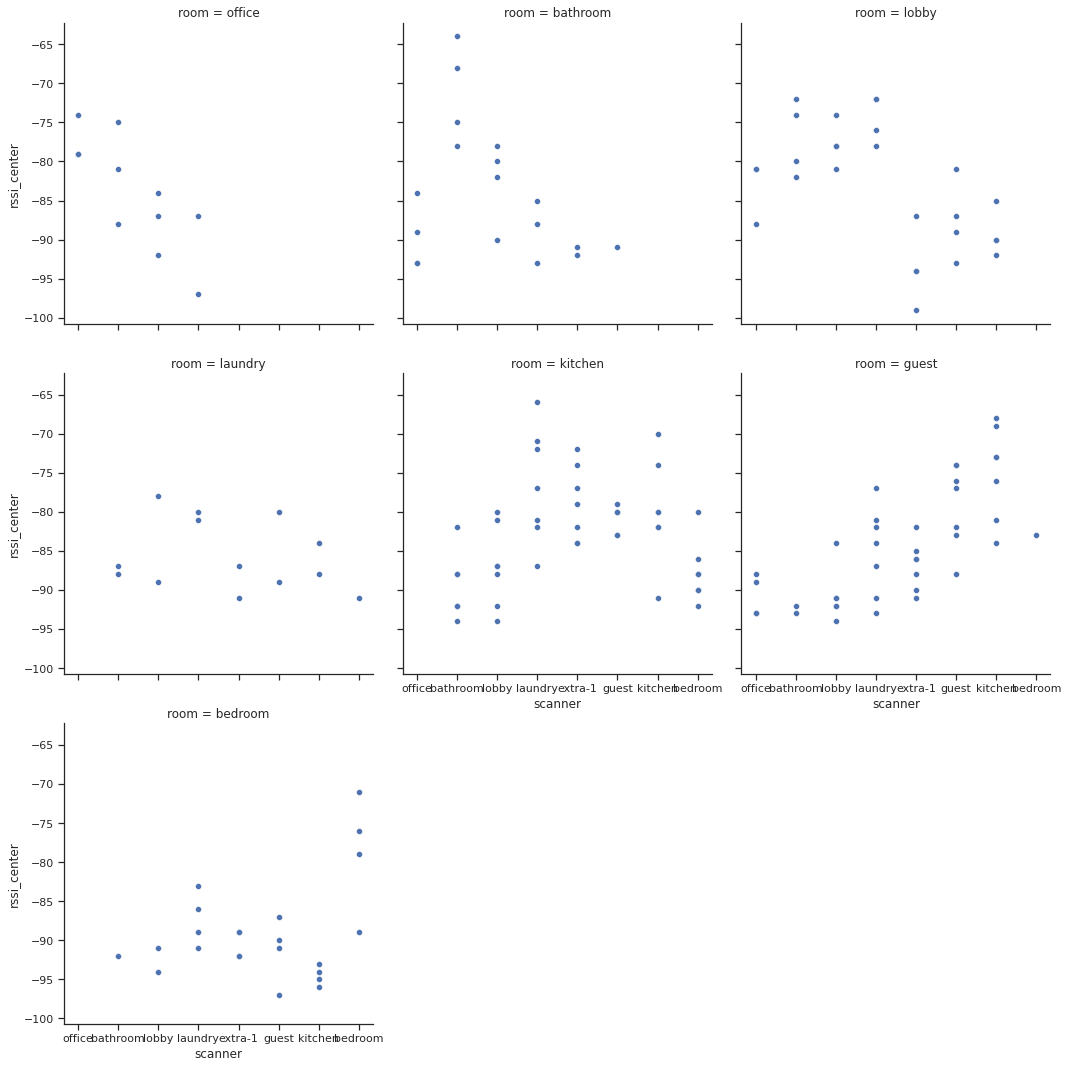

In [187]:
sbs.relplot(data=results_df, x='scanner', y='rssi_center', col='room', kind="scatter", col_wrap=3)

<AxesSubplot:xlabel='scanner', ylabel='rssi_center'>

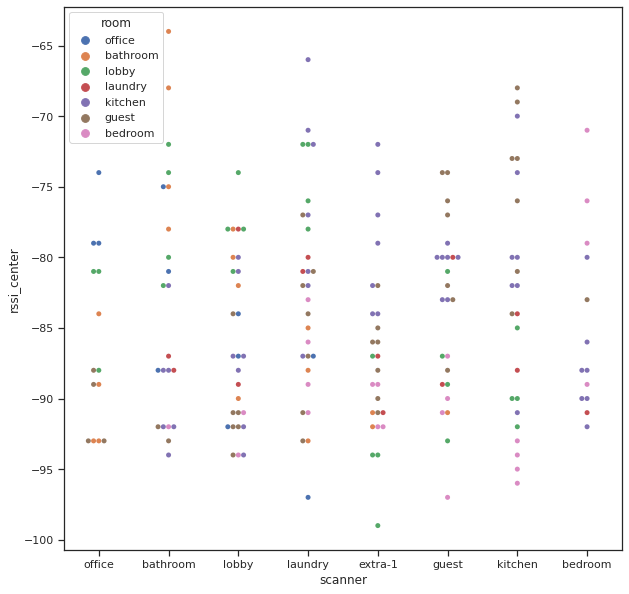

In [188]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
sbs.swarmplot(data=results_df, x='scanner', y='rssi_center', hue='room', ax=ax)

Из данных графиков видно, что для каждого помещения прослеживается свой уникальный паттерн. При этом паттерны пересекаются. Из этого следует, что искомый алгоритм классификации должен определять положение устройства в каждом помещении отдельно, чтобы иметь возможность одновременно позиционировать устройство в нескольких помещениящ, ввиду того, что могут быть пересечения (устройство можно отнести более чем к одному помещению, если сравнивать с имеющимися данными).

__Предположение:__ для фиксированного сканера и фиксированного положения устройства найденные средние уровни сигналов определяют разброс возможных значений. Таким образом искомый алгоритм классификации должен быть обучен в том числе на промежуточных значениях между минимумом и максимумом, так алгоритм получится более генерализованным.

# Наивный алгоритм
Исходя из сделанных выше предположений есть идея наивного алгоритма: имея интервалы возможных значений сигнала для каждого сканера в каждом помещении, найти те интервалы, в которые попадают текущие значения со сканеров. Отсортировать помещения по убыванию количества совпадений с интервалами. Взять помещения со 100% совпадением и считать их включенными. Если таковых нет – считать включенными первые два помещения по количеству совпадений. Если совпадений нет вовсе – считать все помещения выключенными. 

Реализуем этот алгоритм и изучим метрики качества. Нам больше всего нехочется иметь ложно отрицательные результаты (человек в помещении и свет выключился), ложно положительные значения тоже хотелось бы свести к разумному минимум

In [189]:
singal_ranges_df = results_df.groupby(['room', 'scanner']).agg(min=('rssi_center', 'min'), max=('rssi_center', 'max'))
sorted_scanners = sorted(results_df['scanner'].unique())
sorted_rooms = sorted(results_df['room'].unique())

In [190]:
def naive_predict_presence(X):
    signals_df = pd.DataFrame({
        'room':  [rr for r in sorted_rooms for rr in ([r] * len(sorted_scanners))],
        'scanner': sorted_scanners * len(sorted_rooms), 
        'rssi': X * len(sorted_rooms)
    }).set_index(['room', 'scanner'])
    local_ranges_df = singal_ranges_df.copy()
    local_ranges_df['min_diff'] = local_ranges_df['min'] - signals_df['rssi']
    local_ranges_df['max_diff'] = local_ranges_df['max'] - signals_df['rssi']
    local_ranges_df['in_range'] = False
    local_ranges_df.loc[(local_ranges_df['min_diff'] <= 0) & (local_ranges_df['max_diff'] >= 0), 'in_range'] = True
    local_ranges_df['abs_min_diff'] = local_ranges_df[['min_diff', 'max_diff']].abs().min(axis=1)
    local_ranges_df.loc[(local_ranges_df['in_range'] == True), 'abs_min_diff'] = 0
    rooms_perf_df = local_ranges_df.groupby(['room']).agg(
        error_sum=('abs_min_diff', 'sum'), 
        error_mean=('abs_min_diff', 'mean'),
        low_error_scanners=('abs_min_diff', lambda x: sum(x < 5)),
    ).sort_values('error_sum')

    if sum(local_ranges_df['in_range'] == True) == 0:
        return [], rooms_perf_df

    # if rooms_perf_df.iloc[0]['error_sum'] == 0:
    #     return list(rooms_perf_df[rooms_perf_df['error_sum'] == 0].index), rooms_perf_df

    prediction = [rooms_perf_df.iloc[0].name]

    # if rooms_perf_df.iloc[1]['error_sum'] <= 25:
    #     prediction.append(rooms_perf_df.iloc[1].name)

    return prediction, rooms_perf_df

naive_predict_presence([-100]*len(sorted_scanners))

([],
           error_sum  error_mean  low_error_scanners
 room                                               
 office      44.0000     11.0000                   1
 bedroom     49.0000      7.0000                   2
 bathroom    63.0000     10.5000                   0
 kitchen     75.0000     10.7143                   0
 guest       81.0000     10.1250                   0
 laundry     83.0000     11.8571                   0
 lobby       87.0000     12.4286                   1)

### Генерация правдоподобных данных
Чтобы измерять качество алгоритма нужны данные, на которых будет производиться измерение. Чем ближе данные будут к реальным тем лучше. Данные, собранные выше, нельзя назвать естественным и близкими к реальности, так как браслет лежал по 20 минут неподвижно. Эти данные больше подходят для анализа статистических характеристик метода измерения. Но из них можно попробовать построить более реалистичные данные эмитирую перемещение браслета из позиции в позицию, из комнаты в комнату.

In [191]:
session_dur_df = data_df.groupby(['room', 'position']).agg(when_min=('when', 'min'), when_max=('when', 'max'), signals=('when', 'count'))
session_dur_df['when_diff'] = np.round((session_dur_df['when_max'] - session_dur_df['when_min']) / np.timedelta64(1, 's'))
session_dur_df['frequency'] = session_dur_df['signals'] / session_dur_df['when_diff']

In [192]:
PENALIZE_SECONDS = 60
OFF_PENALIZE_SECONDS = 110
PENALTY_AMOUNT = 2
KALMAN_Q = 10
KALMAN_R = 0.15

def generate_data():
    filters = dict([(s, KalmanRSSI(R=KALMAN_R, Q=KALMAN_Q)) for s in sorted_scanners])
    off_signals_history = dict([(s, 0) for s in sorted_scanners])
    delay_signals_history = dict([(s, 0) for s in sorted_scanners])
    used_data_df = data_df
    result_data = []

    for _ in range(3):
        for room in np.random.choice(sorted_rooms, len(sorted_rooms), replace=False):
            room_init = False
            seconds_passed = 0
            positions = used_data_df[used_data_df['room'] == room]['position'].unique()
            for _ in range(3):
                for position in np.random.choice(positions, len(positions), replace=False):
                    signals_per_sec = session_dur_df.loc[(room, position), 'frequency']
                    signals_to_gen = int(np.round(((OFF_PENALIZE_SECONDS / signals_per_sec) * 2) + 10))
                    signals = used_data_df[(used_data_df['room'] == room) & (used_data_df['position'] == position)]
                    signals = signals.sample(n=signals_to_gen, replace=True)
                    
                    for _, row in signals.iterrows():
                        seconds_passed += 1 / signals_per_sec
                        off_signals_history[row['scanner']] = 0
                        delay_signals_history[row['scanner']] = 0
                        filters[row['scanner']].filter(row['rssi'])
                        data_row = [np.round(filters[s].lastMeasurement() or -100, decimals=1) for s in sorted_scanners]

                        for s in sorted_scanners:
                            off_signals_history[s] += 1
                            delay_signals_history[s] += 1
                            if off_signals_history[s] > (OFF_PENALIZE_SECONDS / signals_per_sec):
                                # print('turn off penalty')
                                off_signals_history[s] = 0
                                filters[s].reset(-100)
                            if delay_signals_history[s] > (PENALIZE_SECONDS / signals_per_sec):
                                # print('delay penalty')
                                delay_signals_history[s] = 0
                                filters[s].filter(-100)

                        if room_init:
                            result_data.append(data_row + [room, position])
                        elif seconds_passed > 60:
                            room_init = True

    result_data = pd.DataFrame(columns=sorted_scanners + ['room', 'position'], data=result_data)
    result_data.drop_duplicates(inplace=True)
    return result_data

In [193]:
# upscaled_data_df = generate_data()

Алгоритм выше эмитирует N проходов по квартире по всем комнатам в случайном порядке в каждый проход. В каждой комнате совершается два круга по всем известным положениям, при этом первые полторы минуты в каждой комнате не учитываются, так как датчик движения ждет 2 минуты после последнего зарегистрированного движения, поэтому ошибочное определения положения в первые полторы минуты некритично так как не приведет к отключению света. В каждом положении эмитируется 6 минту прибывания устройства путем случайного выбора M сигналов из известных в данном положении. Каждый сигнал пропускается через фильтр Калмана. Для каждого сигнала берется срез текущих значений со сканеров из фильтров Калмана, этот срез и является элементом обучающей выборки. 

In [435]:
def select_scanner_delay(signal_row, rssi_bin_scanner_data):
    try:
        delay = rssi_bin_scanner_data.loc[(signal_row['scanner'], signal_row['rssi_bin']), 'delay']\
            .sample(n=1).iloc[0]
    except KeyError:
        delay = 5.0
    return delay if delay > 0 else 5.0

def upscale_signals_data(data_df):
    data_df = data_df.copy().sort_values('when_ts')
    data_df['rssi_bin'] = pd.cut(data_df['rssi'], np.arange(-100, 0, 5))
    data_df['delay'] = data_df.groupby(['scanner', 'position'], as_index=False)['when_ts'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])['when_ts']
    data_df['delay'].fillna(0, inplace=True)

    upscaled_data_df = []
    rssi_bins_data_df = data_df.set_index(['scanner', 'rssi_bin']).sort_index()
    data_df = data_df.set_index(['position']).sort_index()

    for pos in data_df.index.unique():
        pos_df = data_df.loc[pos].reset_index()
        new_session_time = pos_df['when_ts'].max()
        session_dur = pos_df['when_ts'].max() - pos_df['when_ts'].min()
        upscaled_data_df.append(pos_df)
        rounds_to_gen = int(np.ceil((OFF_PENALIZE_SECONDS * 15) / session_dur))
        
        for i in range(rounds_to_gen):
            sampled_df = pos_df.sample(n=int(len(pos_df) * 0.8), replace=False, ignore_index=True)
            sampled_df['delay'] = sampled_df.apply(select_scanner_delay, axis=1, args=(rssi_bins_data_df,))
            sampled_df['when_ts'] = sampled_df.groupby('scanner')['delay'].transform(pd.Series.cumsum)
            sampled_df['when_ts'] += new_session_time
            sampled_df['position'] = pos
            new_session_time = sampled_df['when_ts'].max()
            upscaled_data_df.append(sampled_df)

    upscaled_data_df = pd.concat(upscaled_data_df).reset_index().sort_values('when_ts')
    upscaled_data_df['delay'] = upscaled_data_df\
        .groupby(['position', 'scanner'], as_index=False)['when_ts'].rolling(window=2)\
        .apply(lambda x: x.iloc[1] - x.iloc[0])['when_ts']
    upscaled_data_df['delay'].fillna(0, inplace=True)
    return upscaled_data_df


def generate_data_new(data_df):
    gen = HeratbeatGenerator(
        long_delay=60,turn_off_delay=180, kalman=(0.15, 10.), 
        device=None, logging=False)

    positions = data_df['position'].unique()
    scanners = data_df['scanner'].unique()
    data_df = data_df.set_index('position').sort_values('when_ts')
    default_heartbeat = dict(zip(scanners, [-100] * len(scanners)))
    result_data = []
    time_shift = 0
    last_processed_time = None
    prev_room = None
    room_init = False
    seconds_passed = 0

    for _ in range(5):
        for position in np.random.choice(positions, len(positions), replace=False):
            signals_df = data_df.loc[position].reset_index()
            first_signal = signals_df.iloc[0]
            room = first_signal['room']
            seconds_passed = seconds_passed if room == prev_room else 0
            room_init = room == prev_room
            prev_room = room
            time_shift = last_processed_time - first_signal['when_ts'] if last_processed_time else time_shift
            curr_time = first_signal['when_ts'] + time_shift

            for _, row in signals_df.iterrows():
                seconds_passed += row['when_ts'] + time_shift - curr_time
                curr_time = row['when_ts'] + time_shift
                next_signals = gen.process([{'rssi': row['rssi'], 'when': curr_time, 'scanner': row['scanner']}], curr_time)
                data_row = pd.Series({**default_heartbeat, **next_signals}).round(decimals=1)
                data_row['_room'] = room

                if room_init:
                    result_data.append(data_row)
                elif seconds_passed > 60:
                    room_init = True

            last_processed_time = curr_time

    result_data = pd.DataFrame(data=result_data)
    result_data.drop_duplicates(inplace=True)
    return result_data

In [436]:
upscaled_data_df = generate_data_new(upscale_signals_data(data_df))
X, y = (upscaled_data_df.iloc[:, :-1], upscaled_data_df._room.values)

### Проверим работу наивного алгоритма

In [19]:
# y_pred = [naive_predict_presence(x) for x in X]
# y_pred, y_errors = ([i for i, _ in y_pred], [j for _, j in y_pred])

In [20]:
# correct_pred = sum([v in y_pred[i] for i, v in enumerate(y)])
# precision = correct_pred / len(y)
# print('Correctly identified {} out of {}, precision {}'.format(correct_pred, len(y), precision))

Хороший результат! Точность в 98% вполне достаточно. Это не 100%, конечно, иногда свет будет выключаться, но очень редко. Но хочется понять что стоит за этим результатом и есть ли шанс достичь 100%. Конечно это все лишь результат на собранных данных, в реальности ошибок может быть больше.

Изучим на каком месте по ошибках находится верный результат, на каком – ошибочный, какова средняя ошибка верного результата и какую ошибку имеет второе предсказанное "запасное" помещение.

In [21]:
# pred_res_df = pd.DataFrame([{
#     'correct': v in y_pred[i],
#     'predicted_rooms': len(y_pred[i]),
#     'actual_room': v,
#     'signal_error': y_errors[i].loc[v, 'error_sum'],
#     'signal_error_mean': y_errors[i].loc[v, 'error_mean'],
#     'signal_position': y_errors[i].index.get_loc(v),
#     'error_0': y_errors[i].iloc[0]['error_sum'],
#     'error_1': y_errors[i].iloc[1]['error_sum'],
#     'error_2': y_errors[i].iloc[2]['error_sum'],
# } for i, v in enumerate(y)])

In [22]:
# precision_df = pred_res_df.groupby(['actual_room']).agg(correct=('correct', 'sum'), all=('correct', 'count'))
# precision_df['precision'] = precision_df['correct'] / precision_df['all']
# precision_df

In [23]:
# fig = sbs.displot(data=pred_res_df[(pred_res_df['correct'] == True)], x='predicted_rooms').figure

In [24]:
# fig = sbs.displot(data=pred_res_df[pred_res_df['signal_position'].isin([0, 1])], x='error_1', hue='signal_position', col='actual_room', col_wrap=3).figure

Из графиков распределения выше видно, что в случае, когда правильная комната расположена на второй позиции по сумме ошибки, не представляется возможным отделить этот вариант путем отсечения некоторым значением суммарной ошибки без добавления большого количества true-negatives. Возможно существует лучшая метрика для отсечения?

## Другие простые алгоритмы

In [303]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(np.array(X), np.array(y), stratify=y, random_state=42, test_size=0.5)
print('Training {}, testing {}'.format(str(len(y_train)), str(len(y_test))))

Training 31991, testing 31992


In [196]:
def evaluate_estimator(estimator):
    pred_probas = estimator.decision_function(X_test) if  hasattr(estimator, 'decision_function') else estimator.predict_proba(X_test)
    pred_probas_df = pd.DataFrame([dict(list(zip(sorted_rooms, r)) + [('_room', y_test[i])]) for i, r in enumerate(pred_probas)]).dropna()
    _, axes = plt.subplots(1, len(sorted_rooms), figsize=(25, 5))
    for i, room in enumerate(sorted_rooms):
        sbs.scatterplot(data=pred_probas_df, x='_room', y=room, ax=axes[i])
        axes[i].set_title(room)

In [197]:
scoring = {
    # 'auc_roc': metrics.make_scorer(metrics.roc_auc_score, average = 'macro', multi_class='ovr'),
    'accuracy': metrics.make_scorer(metrics.accuracy_score),
    'precision': metrics.make_scorer(metrics.precision_score, average = 'macro'),
    'recall': metrics.make_scorer(metrics.recall_score, average = 'macro'),
    'f1_macro': metrics.make_scorer(metrics.f1_score, average = 'macro'),
    'f1_weighted': metrics.make_scorer(metrics.f1_score, average = 'weighted')
}

kn_estimator = multiclass.OneVsRestClassifier(KNeighborsClassifier())
model_selection.cross_validate(kn_estimator, X_train, y_train, cv=3, scoring=scoring)

{'fit_time': array([0.14612913, 0.16255856, 0.14676762]),
 'score_time': array([0.43126082, 0.45318413, 0.64176583]),
 'test_accuracy': array([0.99667353, 0.99714874, 0.996673  ]),
 'test_precision': array([0.99383172, 0.99435548, 0.9941655 ]),
 'test_recall': array([0.99604253, 0.99579562, 0.99408425]),
 'test_f1_macro': array([0.99492174, 0.99507022, 0.99410422]),
 'test_f1_weighted': array([0.99667908, 0.99715154, 0.99667243])}

              precision    recall  f1-score   support

    bathroom       1.00      1.00      1.00      1831
     bedroom       1.00      1.00      1.00      2356
       guest       1.00      1.00      1.00      4853
     kitchen       1.00      1.00      1.00      5497
     laundry       0.99      0.98      0.99      1060
       lobby       1.00      1.00      1.00      2503
      office       0.99      0.99      0.99       838

    accuracy                           1.00     18938
   macro avg       1.00      1.00      1.00     18938
weighted avg       1.00      1.00      1.00     18938



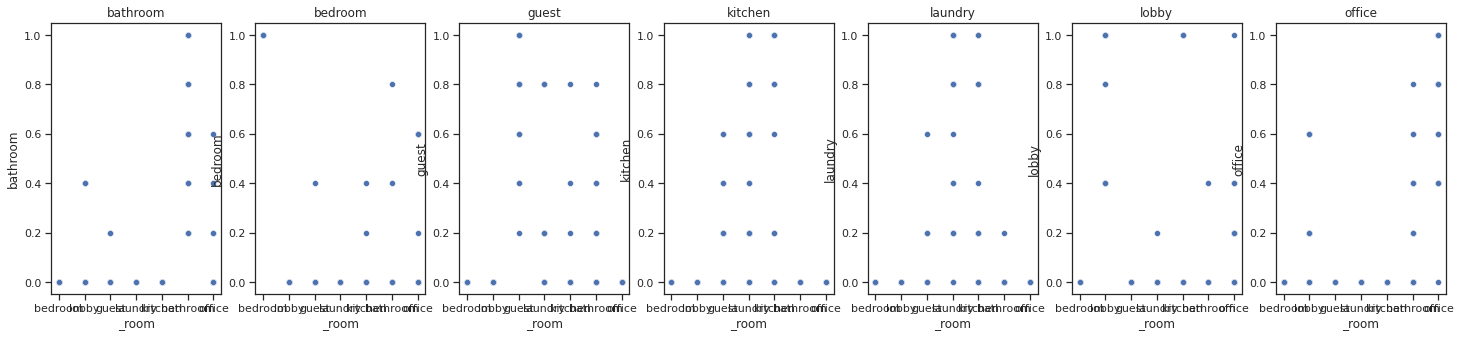

In [198]:
kn_estimator.fit(X_train, y_train)
print(metrics.classification_report(y_test, kn_estimator.predict(X_test)))
evaluate_estimator(kn_estimator)

In [199]:
xgb_estimator = multiclass.OneVsRestClassifier(RandomForestClassifier(n_estimators=5, class_weight='balanced', n_jobs=-1))
model_selection.cross_validate(xgb_estimator, X_train, y_train, cv=3, scoring=scoring)

{'fit_time': array([2.02419806, 0.16046524, 0.16767263]),
 'score_time': array([0.10810995, 0.10446596, 0.11169887]),
 'test_accuracy': array([0.99762395, 0.99746555, 0.99809886]),
 'test_precision': array([0.99688307, 0.99749623, 0.99685755]),
 'test_recall': array([0.99623264, 0.99664448, 0.9972961 ]),
 'test_f1_macro': array([0.99655692, 0.99706599, 0.99707177]),
 'test_f1_weighted': array([0.99762384, 0.9974642 , 0.99809853])}

              precision    recall  f1-score   support

    bathroom       1.00      1.00      1.00      1831
     bedroom       1.00      1.00      1.00      2356
       guest       1.00      1.00      1.00      4853
     kitchen       1.00      1.00      1.00      5497
     laundry       1.00      0.99      0.99      1060
       lobby       1.00      1.00      1.00      2503
      office       1.00      1.00      1.00       838

    accuracy                           1.00     18938
   macro avg       1.00      1.00      1.00     18938
weighted avg       1.00      1.00      1.00     18938



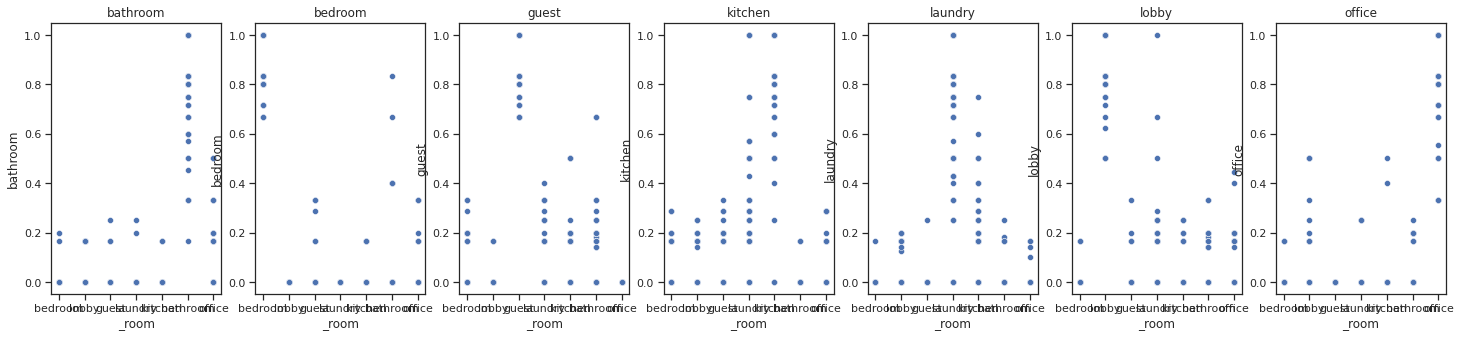

In [200]:
xgb_estimator.fit(X_train, y_train)
print(metrics.classification_report(y_test, xgb_estimator.predict(X_test)))
evaluate_estimator(xgb_estimator)

In [201]:
linear_estimator = multiclass.OneVsRestClassifier(linear_model.LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=0.001, max_iter=10000))
model_selection.cross_validate(linear_estimator, X_train, y_train, cv=3, scoring=scoring)

{'fit_time': array([5.83105183, 5.83254743, 5.5111382 ]),
 'score_time': array([0.09546328, 0.10696483, 0.11608219]),
 'test_accuracy': array([0.91161096, 0.91192777, 0.90320025]),
 'test_precision': array([0.88317946, 0.88363807, 0.87767744]),
 'test_recall': array([0.90233661, 0.90712435, 0.89368619]),
 'test_f1_macro': array([0.88334941, 0.88591019, 0.87434869]),
 'test_f1_weighted': array([0.91836141, 0.91913529, 0.91139393])}

              precision    recall  f1-score   support

    bathroom       0.97      0.96      0.97      1831
     bedroom       0.99      1.00      1.00      2356
       guest       0.99      0.99      0.99      4853
     kitchen       0.95      0.88      0.91      5497
     laundry       0.44      0.80      0.57      1060
       lobby       0.94      0.76      0.84      2503
      office       0.92      0.95      0.94       838

    accuracy                           0.91     18938
   macro avg       0.89      0.91      0.89     18938
weighted avg       0.94      0.91      0.92     18938



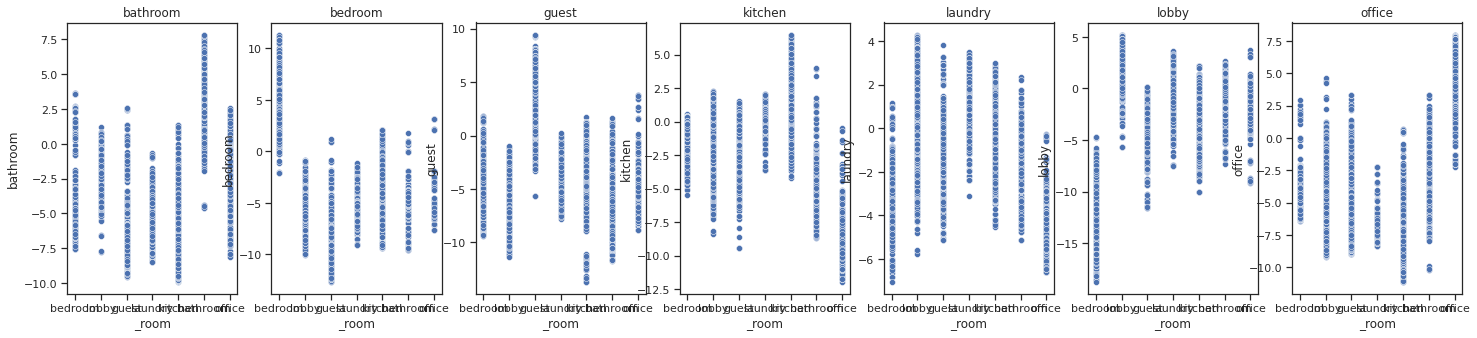

In [202]:
linear_estimator.fit(X_train, y_train)
print(metrics.classification_report(y_test, linear_estimator.predict(X_test)))
evaluate_estimator(linear_estimator)

По объективным метрикам все классические алгоритмы работают лучше наивного алгоритма. Неизместно лишь то насколько они хорошо генерализованы.

## Отбор признаков

In [430]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(np.array(X), np.array(y), stratify=y, random_state=42, test_size=0.5)
print('Training {}, testing {}'.format(str(len(y_train)), str(len(y_test))))

Training 22076, testing 22076


In [346]:
# X_train_big, X_test_big, y_train_big, y_test_big = model_selection.train_test_split(np.array(X), np.array(y), stratify=y, random_state=42, test_size=0.5)

In [297]:
class SelectHighestMean(SelectorMixin, BaseEstimator):
    def fit(self, X, y):
        self.means_ = np.mean(X[y == 1], axis=0)
        return self

    def _more_tags(self):
        return {'requires_y': True}

    def _get_support_mask(self):
        mask = np.zeros(self.means_.shape, dtype=bool)
        sorted_indexes = np.argsort(self.means_, kind="mergesort")
        mask[sorted_indexes[-4:]] = 1
        mask[self.means_ < -90] = 0
        mask[sorted_indexes[-1:]] = 1
        return mask

In [455]:
# y_train_binary = y_train.copy()
# y_train_binary[y_train_binary == 'guest'] = 1
# y_train_binary[y_train_binary != 1] = 0

# SelectHighestMean().fit(X_train, y_train_binary)._get_support_mask()
# print(list(zip(
#     SelectHighestMean().fit(X_train, y_train_binary)._get_support_mask(), 
#     sorted_scanners)))

# print(list(zip(f_classif(X_train, y_train_binary)[1], sorted_scanners)))
# data_train_df = pd.DataFrame(
#     data=np.hstack([X_train, y_train_binary.reshape((len(y_train_binary), 1))]), 
#     columns=sorted_scanners + ['_room'],
#     dtype=np.float64
# )
# data_train_df[data_train_df['_room'] == 1].describe()

clf = pipeline.Pipeline([
    # ('select', SelectHighestMean()),
    # ('scale', preprocessing.StandardScaler()),
    # ('select', SelectFromModel(linear_model.LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=0.01, max_iter=100000))),
    ('classification', RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1))
    # ('classification', linear_model.LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=0.001, max_iter=100000))
    # ('classification', KNeighborsClassifier(2))
])

# feat_sel_estimator = multiclass.OneVsOneClassifier(clf)
feat_sel_estimator = multiclass.OneVsOneClassifier(clf)
# feat_sel_estimator = RandomForestClassifier(n_estimators=50, class_weight='balanced', n_jobs=-1)
# model_selection.cross_validate(feat_sel_estimator, X_train, y_train, cv=3, scoring=scoring)

In [456]:
feat_sel_estimator.fit(X_train, y_train)
print(metrics.classification_report(y_test, feat_sel_estimator.predict(X_test)))
# evaluate_estimator(feat_sel_estimator)

              precision    recall  f1-score   support

    bathroom       1.00      1.00      1.00      1783
     bedroom       1.00      1.00      1.00      2288
       guest       1.00      1.00      1.00      5161
     kitchen       1.00      1.00      1.00      7257
     laundry       1.00      1.00      1.00      1521
       lobby       1.00      1.00      1.00      3021
      office       1.00      1.00      1.00      1045

    accuracy                           1.00     22076
   macro avg       1.00      1.00      1.00     22076
weighted avg       1.00      1.00      1.00     22076



In [459]:
feat_sel_estimator.decision_function([X_test[0]])

array([[0.72597865, 1.76029963, 3.92708333, 6.25      , 5.21759259,
        3.21637427, 0.14065511]])

## Выбор порога
Важнее всего, чтобы свет не выключался когда в помещении кто-то есть, если свет будет гореть чуть дольше там, где никого нет, не так уж и страшно. Иными словами важнее recall чем precision. Исходя из этого нужно выбрать пороги когда считать каждое из помещений активным.

In [460]:
# pred_probas = feat_sel_estimator.decision_function(X_test_big)
pred_probas = feat_sel_estimator.predict_proba(X_test)
pred_probas_df = pd.DataFrame([dict(list(zip(sorted_rooms, r)) + [('_room', y_test[i])]) for i, r in enumerate(pred_probas)]).dropna()
room_thresholds = {}
precisions = []
for i, room in enumerate(sorted_rooms):
    y_true = [1 if x else 0 for x in pred_probas_df['_room'] == room]
    y_pred = list(pred_probas_df[room])
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    ix = np.argmax(recall)
    room_thresholds[room] = thresholds[ix]
    precisions.append(precision[ix])
    # print('\n', room, list(zip(precision, recall, thresholds)))
    print('%s - Best Threshold=%f, Precision=%.3f, Recall=%.3f' % (room, thresholds[ix], precision[ix], recall[ix]))

print('\nMin Precision: {}\nAvg Precision: {}'.format(np.min(precisions), np.mean(precisions)))

AttributeError: 'OneVsOneClassifier' object has no attribute 'predict_proba'

## Проверка боем

Выше были построены различные модели и вычислина их точность. Теперь нужно проверить насколько хорошо они работают на практике.

In [38]:
async def real_world_prediction(predictor):
    filters = dict([(s, KalmanRSSI(R=KALMAN_R, Q=KALMAN_Q)) for s in sorted_scanners])
    scanner_history = dict([(s, 0) for s in sorted_scanners])

    async def penalize_filters():
        while(True):
            await asyncio.sleep(1)
            for s in sorted_scanners:
                scanner_history[s] += 1
                if scanner_history[s] > PENALIZE_SECONDS:
                    print('penalizing {}'.format(s))
                    filters[s].filter(-100)
                    scanner_history[s] = 0
            
    async def run_scanning(): 
        async with Client(
            hostname=str(config.MQTT_BROKER_URL), port=config.MQTT_BROKER_PORT,
            username=str(config.MQTT_USERNAME), password=str(config.MQTT_PASSWORD)) as client:
            async with client.unfiltered_messages() as messages:
                await client.subscribe("room_presence/#")
                async for message in messages:
                    event = jsons.loads(message.payload.decode())
                    if event['id'] != 'eb:cd:02:7f:98:91'.upper():
                        continue

                    scanner = message.topic.split('/')[1]
                    filters[scanner].filter(event['rssi'])
                    scanner_history[scanner] = 0
                    data_row = [filters[s].lastMeasurement() or -100 for s in sorted_scanners]

                    pred_result = list(zip(predictor.classes_, predictor.predict_proba(np.array([data_row]))[0]))
                    max_pred_result = max(pred_result, key=lambda x: x[1])
                    pred_result = [r for r in pred_result if r[1] >= room_thresholds[r[0]]]
                    pred_result = [max_pred_result] if not pred_result else pred_result
                    print(pred_result, scanner, event['rssi'])

    await asyncio.gather(
        asyncio.create_task(penalize_filters()),
        asyncio.create_task(run_scanning())
    )

In [39]:
# await real_world_prediction(xgb_estimator)

## Оптимальный объем выборки
Сбор 100 сигналов на 2 сканера в одном положении занимал от 10 до 20 минут. Хочется сократить это время и понять какой минимум времени нужно ждать, чтобы получить те же средние значения что и в полной выборке. Это можно сделать аналитически и численно. Аналитически путем анализа распределения и задания доверительных интервалов для некоторой точности. Численно путем оптимизации некоторой функции потерь, которая будет равна 1 при 10 сигналах со сканера и в точности совпадающему среднему с средним по всей доступной выборке, равна 0 если объем выборки равен всей доступной выборке.

In [170]:
def get_delay_stats(data_df):
    return data_df.groupby(['position', 'scanner'])\
        .agg(
            mean_rssi=('rssi', 'mean'), 
            std_rssi=('rssi', 'std'), 
            signals=('rssi', 'count'),
            mean_delay=('delay', 'mean'),
            std_delay=('delay', 'std'),
            min_delay=('delay', 'min'),
            max_delay=('delay', 'max'),
        ).reset_index()\
        .pivot(index='position', columns='scanner', values=['mean_rssi'])

In [41]:
get_delay_stats(data_df)

mean_rssi                                      \
scanner                     bathroom  bedroom  extra-1    guest  kitchen   
position                                                                   
bathroom-1637222116.619492  -70.7143      NaN -93.2500 -92.5000      NaN   
bathroom-1637222239.984954  -64.4483      NaN      NaN      NaN      NaN   
bathroom-1637222436.5519    -75.4762      NaN      NaN      NaN      NaN   
bathroom-1637222786.828138  -73.0800      NaN -93.6667      NaN      NaN   
bedroom-1637224899.441276        NaN -77.6500 -91.0000 -97.0000 -92.6000   
bedroom-1637224994.274671   -92.0000 -82.1333 -91.5000 -91.0000 -96.0000   
bedroom-1637225070.761705        NaN -81.8800 -91.5000 -93.0000 -93.7500   
bedroom-1637225191.428329        NaN -74.8800 -90.8333 -90.7500 -94.5000   
guest-1637224171.107522          NaN      NaN -85.8750 -74.0000 -77.3077   
guest-1637224240.792768          NaN      NaN -82.7273 -75.2727 -72.2500   
guest-1637224320.916289          NaN      NaN -90.5000 -83.0000 -74.4286   
guest-1637224418.349517     -93.0000      NaN -91.0000 -81.7778 -81.1000   
guest-1637224502.453198          NaN      NaN -89.3750 -82.1818 -77.0000   
guest-1637224600.915573          NaN      NaN -85.1250 -87.6667 -80.8333   
guest-1637224782.246573     -91.6667 -85.3333 -87.3333 -77.4615 -73.6000   
kitchen-1637223656.993929   -88.3333 -90.5000 -85.2500 -80.9091 -79.2857   
kitchen-1637223720.870339   -94.0000 -88.7778 -76.6250 -78.7500 -79.0000   
kitchen-1637223759.627233   -85.5000 -82.6250 -84.6667 -80.7500 -80.0000   
kitchen-1637223827.555968   -89.3333 -86.0000 -75.6667 -81.7778 -89.2500   
kitchen-1637223887.142044   -85.0000 -90.0000 -81.3000 -81.7500 -82.0000   
kitchen-1637223993.488225        NaN -88.1111 -77.4375 -81.7143 -77.6667   
kitchen-1637224053.476538   -92.8571 -91.5000 -85.2857 -84.2000 -80.0000   
laundry-1637223379.434914   -88.4000      NaN -92.6250 -90.7500 -85.6000   
laundry-1637223528.455919   -88.5714 -91.0000 -87.7500 -85.0000 -86.6000   
lobby-1637223026.962617     -73.8889      NaN -93.6667 -95.0000 -90.6667   
lobby-1637223092.839924     -73.8750      NaN -91.6667 -89.0000 -92.3750   
lobby-1637223159.730842     -77.2500      NaN -99.0000 -86.6667 -89.5000   
lobby-1637223281.578186     -79.2222      NaN -86.3333 -83.6250 -85.5000   
office-1637221275.029067    -89.1250      NaN      NaN      NaN      NaN   
office-1637221547.741976    -79.6667      NaN      NaN      NaN      NaN   
office-1637222011.515473    -79.5556      NaN      NaN      NaN      NaN   

                                                       
scanner                     laundry    lobby   office  
position                                               
bathroom-1637222116.619492      NaN -80.0000 -92.8750  
bathroom-1637222239.984954 -87.5000 -87.3000 -91.2500  
bathroom-1637222436.5519   -94.0000 -80.8947 -92.1250  
bathroom-1637222786.828138 -86.0000 -82.7647 -84.0000  
bedroom-1637224899.441276  -86.5000      NaN      NaN  
bedroom-1637224994.274671  -88.1538 -91.2000      NaN  
bedroom-1637225070.761705  -87.6471      NaN      NaN  
bedroom-1637225191.428329  -92.4167 -94.0000      NaN  
guest-1637224171.107522    -87.5000      NaN -92.0000  
guest-1637224240.792768    -81.1429 -89.0000 -93.0000  
guest-1637224320.916289    -84.5000 -92.5000      NaN  
guest-1637224418.349517    -82.5000 -92.3333      NaN  
guest-1637224502.453198    -88.5714 -94.0000 -93.2000  
guest-1637224600.915573    -89.5000 -92.0000 -88.4286  
guest-1637224782.246573    -73.7500 -91.0000      NaN  
kitchen-1637223656.993929  -69.5000 -89.0000      NaN  
kitchen-1637223720.870339  -73.9000 -85.3333      NaN  
kitchen-1637223759.627233  -79.1250 -94.0000      NaN  
kitchen-1637223827.555968  -81.8333 -91.6000      NaN  
kitchen-1637223887.142044  -84.6667 -89.7500      NaN  
kitchen-1637223993.488225  -74.8750 -87.0000      NaN  
kitchen-1637224053.476538  -81.1538 -87.1250      NaN  
laundry-1637223379.434914  -75.4167 -81.85

In [42]:
data_df_upscaled = upscale_signals_data(data_df)

In [43]:
get_delay_stats(data_df_upscaled[data_df_upscaled['room'] == 'guest']).head(50)

mean_rssi                                      \
scanner                  bathroom  bedroom  extra-1    guest  kitchen   
position                                                                
guest-1637224171.107522       NaN      NaN -85.7109 -74.0324 -77.2692   
guest-1637224240.792768       NaN      NaN -82.8289 -75.4432 -72.2920   
guest-1637224320.916289       NaN      NaN -90.4910 -83.0253 -74.5700   
guest-1637224418.349517  -93.0000      NaN -91.0541 -81.8659 -80.9338   
guest-1637224502.453198       NaN      NaN -89.2828 -82.2847 -77.4132   
guest-1637224600.915573       NaN      NaN -85.0962 -87.3649 -80.8861   
guest-1637224782.246573  -91.6552 -86.0333 -87.2500 -77.5324 -73.8532   

                                                    
scanner                  laundry    lobby   office  
position                                            
guest-1637224171.107522 -87.2857      NaN -91.4375  
guest-1637224240.792768 -81.2897 -88.6154 -93.0000  
guest-1637224320.916289 -84.4458 -92.5000      NaN  
guest-1637224418.349517 -82.6250 -92.3333      NaN  
guest-1637224502.453198 -88.4270 -94.0000 -93.0794  
guest-1637224600.915573 -89.1429 -92.0000 -88.2553  
guest-1637224782.246573 -73.4430 -91.0000      NaN

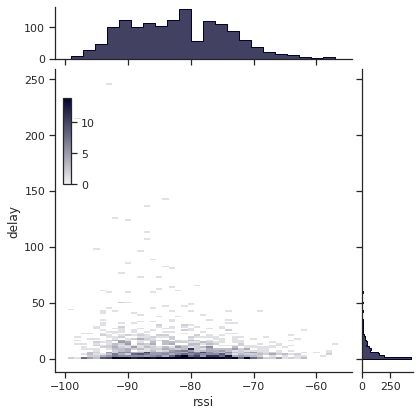

In [44]:
sbs.set_theme(style="ticks")

# Load the planets dataset and initialize the figure
g = sbs.JointGrid(data=data_df, x="rssi", y="delay", marginal_ticks=True)

# Create an inset legend for the histogram colorbar
cax = g.figure.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sbs.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
g.plot_marginals(sbs.histplot, element="step", color="#03012d")

In [45]:
data_df.groupby(['rssi_bin']).agg(mean_delay=('delay', 'mean'), std_delay=('delay', 'std'))

,mean_delay,std_delay
rssi_bin,,
"(-100, -95]",12.8625,31.4430
"(-95, -90]",11.4592,22.2648
"(-90, -85]",10.1224,17.9499
"(-85, -80]",8.2403,13.2637
"(-80, -75]",5.6080,7.2229
"(-75, -70]",5.5571,7.0108
"(-70, -65]",5.5160,6.5517
"(-65, -60]",6.7265,7.7921
"(-60, -55]",5.7000,3.8407


## Поведение Калмана

Нужно изучить как себя ведет фильтр Калмана при разных параметрах, чтобы определиться с оптимальными значениями.

In [438]:
kalman_scanner = 'guest'
kalman_means = results_df[(results_df['scanner'] == kalman_scanner)].groupby(['scanner', 'room', 'position']).agg(rssi_mean=('rssi_center', 'mean'))

In [448]:
test_filters = [
    KalmanRSSI(R=0.08, Q=10),
    KalmanRSSI(R=0.08, Q=20),
    KalmanRSSI(R=0.08, Q=30),
    KalmanRSSI(R=0.08, Q=50),
]
filtered_values = []
counter = 0
for (scanner, room, position), r in kalman_means.iterrows():
    # if position != 'lobby-1636398557.066242': continue
    slice_df = data_df[(data_df['room'] == room) & (data_df['position'] == position) & (data_df['scanner'] == scanner)]
    slice_df = slice_df.sample(len(slice_df), random_state=42)

    for _, signal in slice_df.iterrows():
        counter += 1
        filtered_values.append({
            'id': counter,
            'scanner': scanner,
            'room': room,
            'position': position,
            'rssi': r['rssi_mean'],
            'params': 'Actual Mean',
        })
        filtered_values.append({
            'id': counter,
            'scanner': scanner,
            'room': room,
            'position': position,
            'rssi': signal['rssi'],
            'params': 'Raw RSSI',
        })
        filtered_values.append({
            'id': counter,
            'scanner': scanner,
            'room': room,
            'position': position,
            'rssi': signal['rssi'],
            'params': 'MA',
        })
        for fl in test_filters:
            filtered_values.append({
                'id': counter,
                'scanner': scanner,
                'room': room,
                'position': position,
                'rssi': fl.filter(signal['rssi']),
                'params': 'R={};Q={}'.format(str(fl.R), str(fl.Q)),
            })
    
filtered_values = pd.DataFrame(filtered_values)
filtered_values.loc[filtered_values['params'] == 'MA', 'rssi'] = \
    filtered_values.loc[filtered_values['params'] == 'MA', 'rssi'].rolling(window=30).mean()

<AxesSubplot:xlabel='id', ylabel='rssi'>

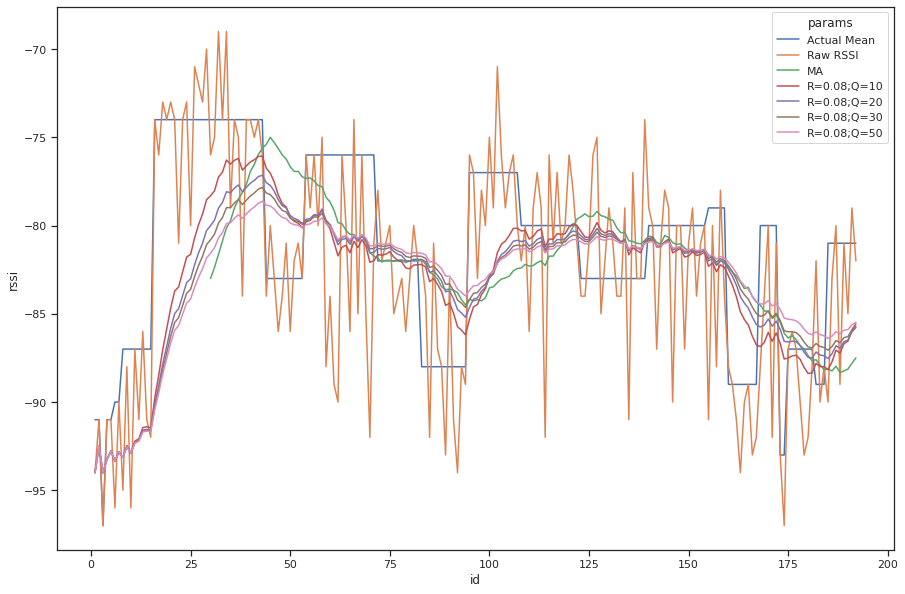

In [449]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
sbs.lineplot(data=filtered_values, x='id', y='rssi', hue='params', ax=axes)

Параметры Q и R влияют на скорость схождения к некоторому среднему. Из проверенных параметров R=0.08 и Q=10 выглядит как хорошей комбинацией, сходимость наступает быстрее других вариантов, при этом волатильность не увиличивается значительно.

## Загрузка собранных данных в базу

In [51]:
from server import models

In [56]:
await models.init_db()

In [53]:
# await models.DeviceSignal.all().delete()
# await models.LearningSession.all().delete()

In [54]:
# scanners = await models.Scanner.filter(uuid__in=data_df['scanner'].unique())
# scanners = dict([(s.uuid, s) for s in scanners])
# rooms = await models.Room.filter(name__in=[s.capitalize() for s in data_df['scanner'].unique()])
# rooms = dict([(s.name.lower(), s) for s in rooms])
# device = await models.Device.get(id=6)
# sessions = dict([(position, await models.LearningSession.create(
#     device_id=device.id,
#     room_id=rooms[position.split('-')[0]].id,
# )) for position in data_df['position'].unique()])

In [55]:
# for _, row in data_df.iterrows():
#     await models.DeviceSignal.create(
#         learning_session_id = sessions[row['position']].id,
#         device_id = device.id,
#         room_id = rooms[row['room']].id,
#         scanner_id = scanners[row['scanner']].id,
#         rssi = row['rssi'],
#         created_at = row['when'],
#         updated_at = row['when'],
#     )

## Проверка с сигналами из базы

In [57]:
db_signals = await models.DeviceSignal.filter(device_id=6).prefetch_related('room', 'scanner', 'learning_session')

In [174]:
db_data_df = pd.DataFrame([{
    'rssi': x.rssi,
    'scanner': x.scanner.id,
    'room': x.room.id,
    'when_ts': x.created_at.timestamp(),
    'position': str(x.learning_session.id),
} for x in db_signals])
db_data_df['delay'] = db_data_df\
    .groupby(['position', 'scanner'], as_index=False)['when_ts'].rolling(window=2)\
    .apply(lambda x: x.iloc[1] - x.iloc[0])['when_ts']
db_data_df['delay'].fillna(0, inplace=True)

In [168]:
def select_scanner_delay(signal_row, rssi_bin_scanner_data):
    try:
        delay = rssi_bin_scanner_data.loc[(signal_row['scanner'], signal_row['rssi_bin']), 'delay']\
            .sample(n=1).iloc[0]
    except KeyError:
        delay = 5.0
    return delay if delay > 0 else 5.0

def upscale_signals_data(data_df):
    data_df = data_df.copy().sort_values('when_ts')
    data_df['rssi_bin'] = pd.cut(data_df['rssi'], np.arange(-100, 0, 5))
    data_df['delay'] = data_df.groupby(['scanner', 'position'], as_index=False)['when_ts'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])['when_ts']
    data_df['delay'].fillna(0, inplace=True)

    upscaled_data_df = []
    rssi_bins_data_df = data_df.set_index(['scanner', 'rssi_bin']).sort_index()
    data_df = data_df.set_index(['position']).sort_index()

    for pos in data_df.index.unique():
        pos_df = data_df.loc[pos].reset_index()
        new_session_time = pos_df['when_ts'].max()
        session_dur = pos_df['when_ts'].max() - pos_df['when_ts'].min()
        upscaled_data_df.append(pos_df)
        rounds_to_gen = int(np.ceil((OFF_PENALIZE_SECONDS * 10) / session_dur))
        
        for i in range(rounds_to_gen):
            sampled_df = pos_df.sample(n=int(len(pos_df) * 0.8), replace=True, ignore_index=True)
            sampled_df['delay'] = sampled_df.apply(select_scanner_delay, axis=1, args=(rssi_bins_data_df,))
            sampled_df['when_ts'] = sampled_df.groupby('scanner')['delay'].transform(pd.Series.cumsum)
            sampled_df['when_ts'] += new_session_time
            sampled_df['position'] = pos
            new_session_time = sampled_df['when_ts'].max()
            upscaled_data_df.append(sampled_df)

    upscaled_data_df = pd.concat(upscaled_data_df).reset_index().sort_values('when_ts')
    upscaled_data_df['delay'] = upscaled_data_df\
        .groupby(['position', 'scanner'], as_index=False)['when_ts'].rolling(window=2)\
        .apply(lambda x: x.iloc[1] - x.iloc[0])['when_ts']
    upscaled_data_df['delay'].fillna(0, inplace=True)
    return upscaled_data_df


def generate_data_new(data_df):
    gen = HeratbeatGenerator(
        long_delay=30,turn_off_delay=180, kalman=(0.15, 10.), 
        device=None, logging=False)

    positions = data_df['position'].unique()
    scanners = data_df['scanner'].unique()
    data_df = data_df.set_index('position').sort_values('when_ts')
    default_heartbeat = dict(zip(scanners, [-100] * len(scanners)))
    result_data = []
    time_shift = 0
    last_processed_time = None
    prev_room = None
    room_init = False
    seconds_passed = 0

    for _ in range(5):
        for position in np.random.choice(positions, len(positions), replace=False):
            signals_df = data_df.loc[position].reset_index()
            first_signal = signals_df.iloc[0]
            room = first_signal['room']
            seconds_passed = seconds_passed if room == prev_room else 0
            room_init = room == prev_room
            prev_room = room
            time_shift = last_processed_time - first_signal['when_ts'] if last_processed_time else time_shift
            curr_time = first_signal['when_ts'] + time_shift

            for _, row in signals_df.iterrows():
                seconds_passed += row['when_ts'] + time_shift - curr_time
                curr_time = row['when_ts'] + time_shift
                next_signals = gen.process([{'rssi': row['rssi'], 'when': curr_time, 'scanner': row['scanner']}], curr_time)
                data_row = pd.Series({**default_heartbeat, **next_signals}).round(decimals=1)
                data_row['_room'] = room

                if room_init:
                    result_data.append(data_row)
                elif seconds_passed > 60:
                    room_init = True

            last_processed_time = curr_time

    result_data = pd.DataFrame(data=result_data)
    result_data.drop_duplicates(inplace=True)
    return result_data

In [131]:
upscaled_data = upscale_signals_data(db_data_df)

In [169]:
generate_data_new(upscaled_data)

,8,4,2,6,7,3,1,5,_room
0,-93.0000,-100.0000,-89.0000,-86.0000,-81.1000,-75.3000,-72.0000,-100.0000,4.0000
1,-93.0000,-100.0000,-89.0000,-82.0000,-81.1000,-75.3000,-72.0000,-100.0000,4.0000
2,-93.0000,-100.0000,-89.0000,-82.0000,-81.1000,-75.3000,-71.2000,-100.0000,4.0000
3,-93.0000,-100.0000,-89.0000,-81.6000,-81.1000,-75.3000,-71.2000,-100.0000,4.0000
4,-93.0000,-100.0000,-89.0000,-81.6000,-81.1000,-75.3000,-72.0000,-100.0000,4.0000
...,...,...,...,...,...,...,...,...,...
85598,-100.0000,-96.5000,-93.2000,-82.9000,-90.9000,-81.5000,-82.2000,-100.0000,4.0000
85599,-100.0000,-96.5000,-93.4000,-82.9000,-90.9000,-81.5000,-82.2000,-100.0000,4.0000
85600,-100.0000,-96.5000,-93.4000,-83.2000,-90.9000,-81.5000,-82.2000,-100.0000,4.0000
85601,-100.0000,-96.5000,-93.4000,-83.2000,-90.9000,-81.5000,-81.3000,-100.0000,4.0000


In [171]:
get_delay_stats(upscaled_data)

mean_rssi                                                        \
scanner          1        2        3        4        5        6        7   
position                                                                   
47             NaN -94.0588      NaN -89.4808      NaN -89.7273      NaN   
48             NaN -84.3226      NaN -79.7222      NaN -97.0000      NaN   
49             NaN -86.8138      NaN -79.3636      NaN      NaN      NaN   
50             NaN -79.9574 -92.6250 -71.2163      NaN      NaN -93.0263   
51             NaN -86.1455      NaN -64.6358      NaN -87.2222      NaN   
52             NaN -80.6522      NaN -75.3034      NaN -92.9412      NaN   
53             NaN -82.9348      NaN -72.4478      NaN -86.0577 -93.8958   
54        -90.3409 -77.3167 -95.0800 -73.8542      NaN -74.5115 -93.7037   
55        -92.0645 -79.4301 -89.0354 -73.7798      NaN -77.4535 -91.6190   
56        -89.8125 -72.7442 -85.6667 -77.1096      NaN -78.2482 -99.0000   
57        -85.5714 -79.2464 -83.3214 -79.1513      NaN -75.4800 -86.2293   
58        -85.8163 -81.3962 -90.9483 -88.5333      NaN -75.8966 -92.4528   
59        -87.0234 -88.0789 -84.9870 -88.5455 -91.0000 -79.3418 -87.2000   
60        -79.5344 -90.0000 -81.1294 -88.3704 -90.5455 -69.4523 -85.4699   
61        -79.7872 -85.2035 -78.6218 -94.0000 -88.8185 -73.8259 -76.6280   
62        -79.9600 -93.8333 -81.2671 -85.6212 -82.4903 -78.8271 -85.0196   
63        -89.2457 -91.2162 -81.2609 -89.3077 -85.9559 -81.6408 -75.1795   
64        -81.9804 -89.6866 -81.8462 -84.8261 -90.0000 -83.8214 -80.5221   
65        -76.9310 -87.0000 -81.5780      NaN -88.0743 -75.4387 -77.6636   
66        -80.1792 -87.2000 -83.9841 -92.8495 -91.3636 -81.2947 -85.5652   
67        -77.7214      NaN -73.7571      NaN      NaN -86.5789 -85.9524   
68        -72.0308 -89.6757 -75.4675      NaN      NaN -81.1081 -82.8907   
69        -74.6688 -92.6744 -82.8945      NaN      NaN -84.7895 -90.3856   
70        -80.9931 -92.1549 -81.6015 -93.0000      NaN -81.9865 -91.0980   
71        -76.7769 -94.0000 -82.2429      NaN      NaN -88.5233 -89.1616   
72        -80.5200 -92.0000 -87.9067      NaN      NaN -89.3077 -85.1897   
73        -73.3109 -91.0000 -77.5887 -91.4688 -84.7500 -74.1928 -87.8667   
74        -92.7031      NaN -97.0000      NaN -77.7467 -86.2828 -90.9252   
75        -96.0000 -91.2639 -91.0000 -92.0000 -81.8252 -87.9395 -91.2328   
76        -93.6098      NaN -93.1304      NaN -81.8714 -87.5414 -92.0510   
77        -94.5833 -94.0000 -90.6000      NaN -74.8132 -92.2750 -90.9024   

                   
scanner         8  
position           
47       -77.8296  
48       -79.9550  
49       -75.7478  
50       -92.7931  
51       -90.7222  
52       -92.3415  
53       -84.3243  
54       -85.0797  
55       -83.2465  
56       -84.2000  
57            NaN  
58            NaN  
59            NaN  
60            NaN  
61            NaN  
62            NaN  
63            NaN  
64            NaN  
65            NaN  
66            NaN  
67       -91.5385  
68       -93.0000  
69            NaN  
70            NaN  
71       -93.0820  
72       -88.4889  
73            NaN  
74            NaN  
75            NaN  
76            NaN  
77            NaN

In [175]:
get_delay_stats(db_data_df)

mean_rssi                                                        \
scanner          1        2        3        4        5        6        7   
position                                                                   
47             NaN -94.2222      NaN -89.1250      NaN -92.0000      NaN   
48             NaN -84.3750      NaN -79.6667      NaN -97.0000      NaN   
49             NaN -86.7273      NaN -79.5556      NaN      NaN      NaN   
50             NaN -80.0000 -92.5000 -70.7143      NaN      NaN -93.2500   
51             NaN -87.3000      NaN -64.4483      NaN -87.5000      NaN   
52             NaN -80.8947      NaN -75.4762      NaN -94.0000      NaN   
53             NaN -82.7647      NaN -73.0800      NaN -86.0000 -93.6667   
54        -90.6667 -77.0000 -95.0000 -73.8889      NaN -74.2500 -93.6667   
55        -92.3750 -79.6000 -89.0000 -73.8750      NaN -76.6000 -91.6667   
56        -89.5000 -72.7692 -86.6667 -77.2500      NaN -78.0625 -99.0000   
57        -85.5000 -79.8000 -83.6250 -79.2222      NaN -75.0000 -86.3333   
58        -85.6000 -81.8571 -90.7500 -88.4000      NaN -75.4167 -92.6250   
59        -86.6000 -88.5000 -85.0000 -88.5714 -91.0000 -79.1250 -87.7500   
60        -79.2857 -89.0000 -80.9091 -88.3333 -90.5000 -69.5000 -85.2500   
61        -79.0000 -85.3333 -78.7500 -94.0000 -88.7778 -73.9000 -76.6250   
62        -80.0000 -94.0000 -80.7500 -85.5000 -82.6250 -79.1250 -84.6667   
63        -89.2500 -91.6000 -81.7778 -89.3333 -86.0000 -81.8333 -75.6667   
64        -82.0000 -89.7500 -81.7500 -85.0000 -90.0000 -84.6667 -81.3000   
65        -77.6667 -87.0000 -81.7143      NaN -88.1111 -74.8750 -77.4375   
66        -80.0000 -87.1250 -84.2000 -92.8571 -91.5000 -81.1538 -85.2857   
67        -77.3077      NaN -74.0000      NaN      NaN -87.5000 -85.8750   
68        -72.2500 -89.0000 -75.2727      NaN      NaN -81.1429 -82.7273   
69        -74.4286 -92.5000 -83.0000      NaN      NaN -84.5000 -90.5000   
70        -81.1000 -92.3333 -81.7778 -93.0000      NaN -82.5000 -91.0000   
71        -77.0000 -94.0000 -82.1818      NaN      NaN -88.5714 -89.3750   
72        -80.8333 -92.0000 -87.6667      NaN      NaN -89.5000 -85.1250   
73        -73.6000 -91.0000 -77.4615 -91.6667 -85.3333 -73.7500 -87.3333   
74        -92.6000      NaN -97.0000      NaN -77.6500 -86.5000 -91.0000   
75        -96.0000 -91.2000 -91.0000 -92.0000 -82.1333 -88.1538 -91.5000   
76        -93.7500      NaN -93.0000      NaN -81.8800 -87.6471 -91.5000   
77        -94.5000 -94.0000 -90.7500      NaN -74.8800 -92.4167 -90.8333   

                   
scanner         8  
position           
47       -78.0588  
48       -80.5714  
49       -75.6250  
50       -92.8750  
51       -91.2500  
52       -92.1250  
53       -84.0000  
54       -84.7500  
55       -83.2500  
56       -84.0000  
57            NaN  
58            NaN  
59            NaN  
60            NaN  
61            NaN  
62            NaN  
63            NaN  
64            NaN  
65            NaN  
66            NaN  
67       -92.0000  
68       -93.0000  
69            NaN  
70            NaN  
71       -93.2000  
72       -88.4286  
73            NaN  
74            NaN  
75            NaN  
76            NaN  
77            NaN